<a href="https://colab.research.google.com/github/ozturkergin/ozturkergin/blob/main/tefas_fon_analiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import & Install

In [1]:
pip install marshmallow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.5 MB/s eta 0:00:00


In [2]:
pip install PyPortfolioOpt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00


In [9]:
import yfinance as yf
import requests
import pandas as pd
import math
import ssl

from datetime import datetime, timedelta, date
from typing import Dict, List, Optional, Union
from marshmallow import Schema, fields, EXCLUDE, pre_load, post_load
from requests.adapters import HTTPAdapter
from urllib3.poolmanager import PoolManager


In [10]:
# Special thanks to https://github.com/burakyilmaz321

class InfoSchema(Schema):
    date = fields.Date(data_key="TARIH", allow_none=True)
    price = fields.Float(data_key="FIYAT", allow_none=True)
    code = fields.String(data_key="FONKODU", allow_none=True)
    title = fields.String(data_key="FONUNVAN", allow_none=True)
    market_cap = fields.Float(data_key="PORTFOYBUYUKLUK", allow_none=True)
    number_of_shares = fields.Float(data_key="TEDPAYSAYISI", allow_none=True)
    number_of_investors = fields.Float(data_key="KISISAYISI", allow_none=True)

    # pylint: disable=no-self-use
    # pylint: disable=unused-argument
    @pre_load
    def pre_load_hook(self, input_data, **kwargs):
        # Convert milliseconds Unix timestamp to date
        seconds_timestamp = int(input_data["TARIH"]) / 1000
        input_data["TARIH"] = date.fromtimestamp(seconds_timestamp).isoformat()
        return input_data

    @post_load
    def post_load_hool(self, output_data, **kwargs):
        # Fill missing fields with default None
        output_data = {f: output_data.setdefault(f) for f in self.fields}
        return output_data

    # pylint: enable=no-self-use
    # pylint: enable=unused-argument

    class Meta:
        unknown = EXCLUDE

class BreakdownSchema(Schema):
    date = fields.Date(data_key="TARIH", allow_none=True)
    tmm = fields.Float(data_key="TMM (%)", allow_none=True)
    repo = fields.Float(data_key="R", allow_none=True)
    code = fields.String(data_key="FONKODU", allow_none=True)
    other = fields.Float(data_key="D", allow_none=True)
    stock = fields.Float(data_key="HS", allow_none=True)
    eurobonds = fields.Float(data_key="EUT", allow_none=True)
    bank_bills = fields.Float(data_key="BB", allow_none=True)
    derivatives = fields.Float(data_key="T", allow_none=True)
    reverse_repo = fields.Float(data_key="TR", allow_none=True)
    term_deposit = fields.Float(data_key="VM", allow_none=True)
    treasury_bill = fields.Float(data_key="HB", allow_none=True)
    foreign_equity = fields.Float(data_key="YHS", allow_none=True)
    government_bond = fields.Float(data_key="DT", allow_none=True)
    precious_metals = fields.Float(data_key="KM", allow_none=True)
    commercial_paper = fields.Float(data_key="FB", allow_none=True)
    fx_payable_bills = fields.Float(data_key="DB", allow_none=True)
    foreign_securities = fields.Float(data_key="YMK", allow_none=True)
    private_sector_bond = fields.Float(data_key="OST", allow_none=True)
    participation_account = fields.Float(data_key="KH", allow_none=True)
    foreign_currency_bills = fields.Float(data_key="DÖT", allow_none=True)
    asset_backed_securities = fields.Float(data_key="VDM", allow_none=True)
    real_estate_certificate = fields.Float(data_key="GAS", allow_none=True)
    foreign_debt_instruments = fields.Float(data_key="YBA", allow_none=True)
    government_lease_certificates = fields.Float(data_key="KKS", allow_none=True)
    fund_participation_certificate = fields.Float(data_key="FKB", allow_none=True)
    government_bonds_and_bills_fx = fields.Float(data_key="KBA", allow_none=True)
    private_sector_lease_certificates = fields.Float(data_key="OSKS", allow_none=True)

    # pylint: disable=no-self-use
    # pylint: disable=unused-argument
    @pre_load
    def pre_load_hook(self, input_data, **kwargs):
        # Convert milliseconds Unix timestamp to date
        seconds_timestamp = int(input_data["TARIH"]) / 1000
        input_data["TARIH"] = date.fromtimestamp(seconds_timestamp).isoformat()
        return input_data

    @post_load
    def post_load_hook(self, output_data, **kwargs):
        # Replace None values with 0 for float fields
        output_data = {
            k: v
            if not (isinstance(self.fields[k], fields.Float) and v is None)
            else 0.0
            for k, v in output_data.items()
        }
        # Fill missing fields with default None
        output_data = {f: output_data.setdefault(f) for f in self.fields}
        return output_data

    # pylint: enable=no-self-use
    # pylint: enable=unused-argument

    class Meta:
        unknown = EXCLUDE

class tefas_get:

    root_url = "https://fundturkey.com.tr"
    detail_endpoint = "/api/DB/BindHistoryAllocation"
    info_endpoint = "/api/DB/BindHistoryInfo"
    headers = {
        "Connection": "keep-alive",
        "X-Requested-With": "XMLHttpRequest",
        "User-Agent": (
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36"
        ),
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
        "Accept": "application/json, text/javascript, */*; q=0.01",
        "Origin": "https://fundturkey.com.tr",
        "Referer": "https://fundturkey.com.tr/TarihselVeriler.aspx",
    }

    def __init__(self):
        self.session = _get_session()
        _ = self.session.get(self.root_url)
        self.cookies = self.session.cookies.get_dict()

    def fetch(
        self,
        start: Union[str, datetime],
        end: Optional[Union[str, datetime]] = None,
        name: Optional[str] = None,
        columns: Optional[List[str]] = None,
    ) -> pd.DataFrame:

        start_date_initial = datetime.strptime(start, "%Y-%m-%d")
        end_date_initial = datetime.strptime(end or start, "%Y-%m-%d")
        counter = 1
        start_date = start_date_initial
        end_date = end_date_initial

        range_date = end_date_initial - start_date_initial
        range_interval = 90
        #print(range_date.days)

        info_schema = InfoSchema(many=True)
        # detail_schema = BreakdownSchema(many=True)
        merged = pd.DataFrame()

        if range_date.days > range_interval :
          counter = range_date.days / range_interval
          counter = math.ceil(counter)
          end_date = start_date + timedelta(days=range_interval)

        while counter > 0:
          counter -= 1
          #print(counter)
          #print(start_date)
          #print(end_date)

          data = {
              "fontip": "YAT",
              "bastarih": _parse_date(start_date),
              "bittarih": _parse_date(end_date),
              "fonkod": name.upper() if name else "",
          }

          # General info pane
          info = self._do_post(self.info_endpoint, data)
          info = info_schema.load(info)
          info = pd.DataFrame(info, columns=info_schema.fields.keys())
          #print(info)

          # Portfolio breakdown pane
          #detail = self._do_post(self.detail_endpoint, data)
          #detail = detail_schema.load(detail)
          #detail = pd.DataFrame(detail, columns=detail_schema.fields.keys())
          #print(detail)

          merged = pd.concat([merged, info])

          # Return only desired columns
          merged = merged[columns] if columns else merged

          if counter > 0 :
            start_date = end_date + timedelta(days=1)
            end_date = end_date + timedelta(days=range_interval)
            if end_date > end_date_initial :
              end_date = end_date_initial

        return merged

    def _do_post(self, endpoint: str, data: Dict[str, str]) -> Dict[str, str]:
        # TODO: error handling. this is quiet fishy now.
        response = self.session.post(
            url=f"{self.root_url}/{endpoint}",
            data=data,
            cookies=self.cookies,
            headers=self.headers,
        )
        return response.json().get("data", {})

def _parse_date(date: Union[str, datetime]) -> str:
    if isinstance(date, datetime):
        formatted = datetime.strftime(date, "%d.%m.%Y")
    elif isinstance(date, str):
        try:
            parsed = datetime.strptime(date, "%Y-%m-%d")
        except ValueError as exc:
            raise ValueError(
                "Date string format is incorrect. " "It should be `YYYY-MM-DD`"
            ) from exc
        else:
            formatted = datetime.strftime(parsed, "%d.%m.%Y")
    else:
        raise ValueError(
            "`date` should be a string like 'YYYY-MM-DD' "
            "or a `datetime.datetime` object."
        )
    return formatted

def _get_session() -> requests.Session:
    """
    Create and return a custom requests session with a modified SSL context.

    This function configures a custom SSL context to use the `OP_LEGACY_SERVER_CONNECT`
    option, which allows for legacy server connections, addressing specific issues
    with OpenSSL 3.0.0.

    The custom session uses a custom HTTP adapter that incorporates this modified
    SSL context for the session's connections.

    This approach is based on solutions found at:
    - https://stackoverflow.com/questions/71603314/ssl-error-unsafe-legacy-renegotiation-disabled/
    - https://github.com/urllib3/urllib3/issues/2653
    """

    class CustomHttpAdapter(HTTPAdapter):
        def __init__(self, ssl_context=None, **kwargs):
            self.ssl_context = ssl_context
            super().__init__(**kwargs)

        def init_poolmanager(
            self, connections, maxsize, block=False
        ):  # pylint: disable=arguments-differ
            self.poolmanager = PoolManager(
                num_pools=connections,
                maxsize=maxsize,
                block=block,
                ssl_context=self.ssl_context,
            )

    ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
    ctx.options |= 0x4  # OP_LEGACY_SERVER_CONNECT
    session = requests.session()
    session.mount("https://", CustomHttpAdapter(ctx))
    return session

# Define Date for Analysis

In [5]:
time_delta = 365
print('Input # days to specify start date:')
try:
  time_delta = int(input())
except ValueError:
  print("Invalid input. Please enter a valid integer.")

start_date_calc = date.today() - timedelta(days=time_delta)
print("Start date will be "+ str(start_date_calc))

Input # days to specify start date:
30
Start date will be 2023-09-10


# Extract Data

In [6]:
# Get Gold Prices from Yahoo Finance
df_fetch_gold = yf.download('GC=F', start_date_calc.strftime("%Y-%m-%d"), date.today().strftime("%Y-%m-%d"), progress=False)
df_Gold = df_fetch_gold[['Close']].rename(columns={'Close': 'GOLD'})
df_Gold['CalDay'] = df_Gold.index.strftime('%Y-%m-%d')
df_Gold.set_index(['CalDay'], inplace=True)
df_Gold

,GOLD
CalDay,
2023-09-11,1923.300049
2023-09-12,1911.300049
2023-09-13,1909.099976
2023-09-14,1910.000000
2023-09-15,1923.699951
2023-09-18,1931.500000
2023-09-19,1932.000000
2023-09-20,1945.599976
2023-09-21,1919.199951


In [7]:
# Get TRY/USD Prices from Yahoo Finance
df_fetch_USDTRY = yf.download('USDTRY=X', start_date_calc.strftime("%Y-%m-%d"), date.today().strftime("%Y-%m-%d"), progress=False, interval="1d")
df_USDTRY = df_fetch_USDTRY[['Close']].rename(columns = {'Close': 'USDTRY'})
df_USDTRY['CalDay'] = df_USDTRY.index.strftime('%Y-%m-%d')
df_USDTRY.set_index(['CalDay'], inplace=True)
df_USDTRY

,USDTRY
CalDay,
2023-09-11,26.665091
2023-09-12,26.866871
2023-09-13,26.919201
2023-09-14,26.885500
2023-09-15,26.944401
2023-09-18,26.786020
2023-09-19,26.987499
2023-09-20,27.018299
2023-09-21,27.022800


In [12]:
tefas = tefas_get()

assets = ['AKU','ST1','AFO', 'OJK', 'AFT', 'ALE', 'AOY', 'TCD', 'GUM']

today_1_year_ago = date.today() - timedelta(days=time_delta)
date_start = today_1_year_ago.strftime("%Y-%m-%d")
date_end = date.today().strftime("%Y-%m-%d")

df = pd.DataFrame()
fetched_data = pd.DataFrame()

for fon in assets:
#  print(fon)
  fetched_data = tefas.fetch(start=date_start, end=date_end, name=fon, columns=["date", "price"])
  fetched_data['CalDay'] = pd.to_datetime(fetched_data['date'], errors='coerce')
  fetched_data['CalDay'] = fetched_data['CalDay'].dt.strftime('%Y-%m-%d')
  fetched_data.set_index(['CalDay'], inplace=True)
  fetched_data.drop(['date'], axis=1)
  new_df = pd.DataFrame(fetched_data)
  new_df.drop(['date'], axis=1)
  new_df.rename(columns = {'price': fon}, inplace=True)
  df = pd.concat([df, new_df])
  df.fillna(0,inplace=True)

df = df.groupby(['CalDay']).sum(numeric_only=True)

df = pd.merge(df, df_USDTRY, left_index=True, right_index=True, how='outer')
df.fillna(inplace=True,method='ffill')
df.fillna(inplace=True,method='bfill')

df = pd.merge(df, df_Gold, left_index=True, right_index=True, how='outer')
df.fillna(inplace=True,method='ffill')
df.fillna(inplace=True,method='bfill')

df

,AKU,ST1,AFO,OJK,AFT,ALE,AOY,TCD,GUM,USDTRY,GOLD
CalDay,,,,,,,,,,,
2023-09-11,0.482114,152.900996,0.359868,3.308703,0.292945,3.921778,0.198580,28.097932,2.841303,26.665091,1923.300049
2023-09-12,0.471009,150.823198,0.360112,3.305194,0.295369,3.925028,0.199469,27.928208,2.848945,26.866871,1911.300049
2023-09-13,0.470231,152.666022,0.359997,3.303958,0.296978,3.928184,0.199662,27.823170,2.833352,26.919201,1909.099976
2023-09-14,0.462581,149.413216,0.361249,3.310965,0.295072,3.931328,0.201075,27.411557,2.829026,26.885500,1910.000000
2023-09-15,0.469881,150.893844,0.357127,3.289273,0.296059,3.934458,0.203232,27.516483,2.781826,26.944401,1923.699951
2023-09-18,0.458440,148.868954,0.359682,3.298836,0.295645,3.944019,0.204767,27.516424,2.857195,26.786020,1931.500000
2023-09-19,0.444538,141.073672,0.360992,3.309466,0.291863,3.947249,0.200143,26.638527,2.854553,26.987499,1932.000000
2023-09-20,0.450312,143.757019,0.362391,3.323039,0.290368,3.950496,0.199184,26.760856,2.880486,27.018299,1945.599976
2023-09-21,0.447029,141.050019,0.362635,3.325345,0.290764,3.953800,0.201029,26.869762,2.890752,27.022800,1919.199951


In [13]:
df_initial_coef = 1000 / df
df_initial_coef = df_initial_coef.iloc[0]

df_normalized = df * df_initial_coef
df_normalized

,AKU,ST1,AFO,OJK,AFT,ALE,AOY,TCD,GUM,USDTRY,GOLD
CalDay,,,,,,,,,,,
2023-09-11,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2023-09-12,976.966029,986.410828,1000.678026,998.939464,1008.274591,1000.828706,1004.476785,993.959555,1002.689611,1007.567209,993.760724
2023-09-13,975.352303,998.463228,1000.358465,998.565903,1013.767089,1001.633443,1005.448686,990.221273,997.201636,1009.529701,992.616819
2023-09-14,959.484686,977.189292,1003.837518,1000.683652,1007.260749,1002.435120,1012.564206,975.572046,995.679095,1008.265841,993.084777
2023-09-15,974.626333,986.872865,992.383318,994.127608,1010.629982,1003.233227,1023.426327,979.306342,979.066998,1010.474753,1000.207925
2023-09-18,950.895431,973.629721,999.483144,997.017865,1009.216747,1005.671152,1031.156209,979.304242,1005.593208,1004.535132,1004.263480
2023-09-19,922.059928,922.647175,1003.123367,1000.230604,996.306474,1006.494758,1007.870883,948.060057,1004.663353,1012.091040,1004.523450
2023-09-20,934.036348,940.196747,1007.010904,1004.332816,991.203127,1007.322699,1003.041595,952.413722,1013.790504,1013.246103,1011.594617
2023-09-21,927.226755,922.492480,1007.688930,1005.029765,992.554916,1008.165174,1012.332561,956.289666,1017.403635,1013.414914,997.868197


In [14]:
df_normalized_USD = df_normalized.divide( df_USDTRY["USDTRY"], axis='index' )
df_normalized_USD.dropna( axis='index', inplace=True )
df_normalized_USD

,AKU,ST1,AFO,OJK,AFT,ALE,AOY,TCD,GUM,USDTRY,GOLD
CalDay,,,,,,,,,,,
2023-09-11,37.502217,37.502217,37.502217,37.502217,37.502217,37.502217,37.502217,37.502217,37.502217,37.502217,37.502217
2023-09-12,36.363223,36.714764,37.245797,37.181087,37.528546,37.251406,37.387189,36.995732,37.320670,37.502217,36.988331
2023-09-13,36.232588,37.091117,37.161522,37.094931,37.659628,37.208885,37.350614,36.784943,37.044251,37.502217,36.873933
2023-09-14,35.687813,36.346331,37.337506,37.220199,37.464832,37.285344,37.662093,36.286178,37.034055,37.502217,36.937560
2023-09-15,36.171758,36.626269,36.830781,36.895517,37.507978,37.233458,37.982894,36.345449,36.336566,37.502217,37.121179
2023-09-18,35.499691,36.348428,37.313611,37.221575,37.676995,37.544627,38.496059,36.560274,37.541718,37.502217,37.492075
2023-09-19,34.166186,34.187946,37.169927,37.062738,36.917332,37.294851,37.345842,35.129600,37.226990,37.502217,37.221806
2023-09-20,34.570509,34.798517,37.271440,37.172318,36.686363,37.282980,37.124528,35.250691,37.522366,37.502217,37.441092
2023-09-21,34.312756,34.137560,37.290322,37.191918,36.730276,37.307946,37.462163,35.388252,37.649822,37.502217,36.926898


# Plot Data

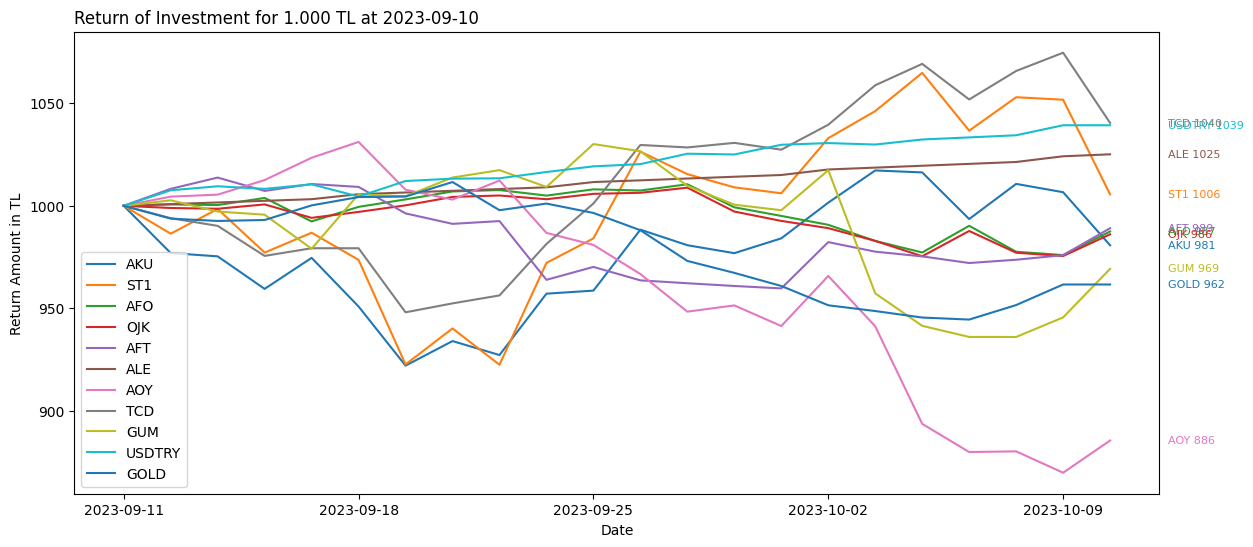

In [15]:
import matplotlib.pyplot as plt

ax = df_normalized.plot(kind="line",figsize=(14,6))

for line, name in zip(ax.lines, df.columns):
    y = line.get_ydata()[-1]
    ax.annotate(name + ' ' + str(round(y)), xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=8, va="center")

plt.title("Return of Investment for 1.000 TL at "+str(date_start), loc = 'left')
plt.xlabel("Date")
plt.ylabel("Return Amount in TL")
plt.show()


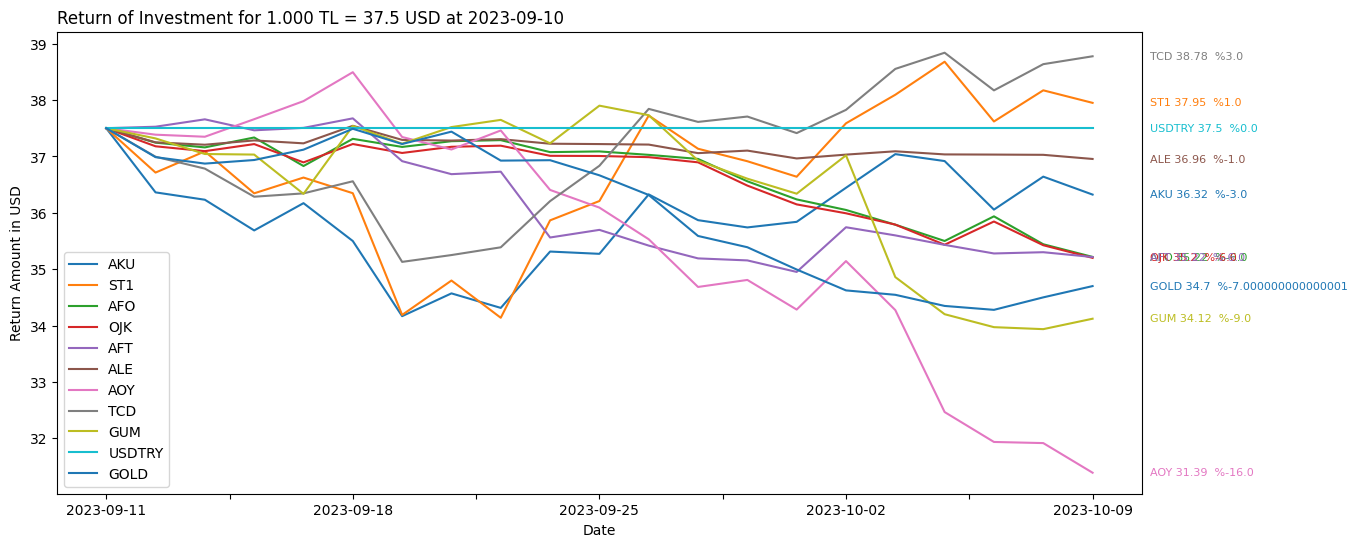

In [16]:
import matplotlib.pyplot as plt

ax = df_normalized_USD.plot(kind="line",figsize=(14,6))

for line, name in zip(ax.lines, df.columns):
    y = line.get_ydata()[-1]
    strt = line.get_ydata()[0]
    ax.annotate(name + ' ' + str(round(y,2)) + '  %' +str( round((y - strt)/strt,2)*100) , xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=8, va="center")

plt.title("Return of Investment for 1.000 TL = " + str(round(df_normalized_USD.iloc[0,0],2)) + " USD at "+str(date_start), loc = 'left')
plt.xlabel("Date")
plt.ylabel("Return Amount in USD")
plt.show()

# Analyze Options

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(df_normalized_USD)
print(mu)

S = risk_models.sample_cov(df)

#optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Max Sharpe Results")
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

ef = EfficientFrontier(mu, S)
weights = ef.max_quadratic_utility()
cleaned_weights = ef.clean_weights()
print("Max Quadratic Utility")
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

AKU      -0.331183
ST1       0.162058
AFO      -0.547030
OJK      -0.549748
AFT      -0.547283
ALE      -0.168694
AOY      -0.893829
TCD       0.524595
GUM      -0.695961
USDTRY    0.000000
GOLD     -0.624144
dtype: float64
Max Sharpe Results
OrderedDict([('AKU', 0.0), ('ST1', 0.0), ('AFO', 0.0), ('OJK', 0.0), ('AFT', 0.0), ('ALE', 0.0), ('AOY', 0.0), ('TCD', 1.0), ('GUM', 0.0), ('USDTRY', 0.0), ('GOLD', 0.0)])
Expected annual return: 52.5%
Annual volatility: 25.8%
Sharpe Ratio: 1.96
Max Quadratic Utility
OrderedDict([('AKU', 0.0), ('ST1', 0.0), ('AFO', 0.0), ('OJK', 0.0), ('AFT', 0.0), ('ALE', 0.0), ('AOY', 0.0), ('TCD', 1.0), ('GUM', 0.0), ('USDTRY', 0.0), ('GOLD', 0.0)])
Expected annual return: 52.5%
Annual volatility: 25.8%
Sharpe Ratio: 1.96


(0.5245952585390024, 0.25793189975212216, 1.956311952976459)